# Final Project ECE 285

This is my attempt at working with the 285 final project. So this is the outlook so far:

- **Part I.** *Set up*: this is where we import most of the libraries we will be using, set up cuda as the device we will be using, and download the dataset from the internet.
- **Part II.** *Cleaning Data*: the data needs to be resized and sorted to eliminate the images that are corrupted. After this it is stored in another folder.
- **Part III.** *DCGAN*: this is where the Generator and Discriminator are defined and initialized, as well as the hyperparameter values as per the DCGAN paper.
- **Part IV.**  *Loss Functions and Optimizers*: we define the loss function and initialize the optimizers for the Generator and Discriminator respectively.
- **Part V.** *Training*: the generator and discriminator are finally trained. The weights are saved for perpetuity and used for image generation and later on for supervised classification tasks.
- **Part VI.** *Results*: we display the loss of the generator and discriminator in terms of the number of iterations and we display the final images created by the generator.
- **Part VII.** *Supervised Learning - Set Up*: the COCO dataset is downloaded and cleaned and the previously trained models are reloaded.
- **Part VIII.** *Supervised Learning - Transfer Learning*: here we use the discriminator as a feature extractor using a feature extractor class that is initialized with the trained weights. Then the COCO images are passed through it and the features are saved.
- **Part IX.** *Supervised Learning - Building a CNN*: this is where L2-SVM is created to do classification.

# Part I. Set Up
Downloading the Oxford-IIIT Pet Dataset and setting up the libraries.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import torchvision.utils as vutils

import tarfile
from PIL import Image
import os
import random

import numpy as np
import matplotlib.pyplot as plt
import cv2

%load_ext autoreload
%autoreload 2

# setup
device = None

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('using device:', device)

using device: cuda


## Downlading the Oxford Pet Dataset

Only run once. The total size of the pet dataset is of 7394 images. The path to the images is 'data/pet_data/images/'. The images are jpg and are all of either cats or dogs of different breeds. We also extract the labels from the dataset and save them to 'data/pet_data/annotations/'.

In [4]:
# Specify the path to your .tar.gz file
file_path = 'data/pet_data/images.tar.gz'

# Specify the directory where you want to extract the images
extract_directory = 'data/pet_data/'

# Open the .tar.gz file
with tarfile.open(file_path, 'r:gz') as tar:
    # Get the list of member names (file names) in the .tar.gz file
    member_names = tar.getnames()
        
    # Extract the batch of images
    for member_name in member_names:
        tar.extract(member=member_name, path=extract_directory)    

In [5]:
# Specify the path to your .tar.gz file
file_path = 'data/pet_data/annotations.tar.gz'

# Specify the directory where you want to extract the images
extract_directory = 'data/pet_data/'

# Open the .tar.gz file
with tarfile.open(file_path, 'r:gz') as tar:
    # Get the list of member names (file names) in the .tar.gz file
    member_names = tar.getnames()
    
    # Extract the batch of labels
    for member_name in member_names:
        tar.extract(member=member_name, path=extract_directory)

## Downloading the Flickr-Face-Dataset HQ
This dataset was partially downloaded. The 70k images were too much so only 10k images were used. These were taken directly from the google Drive and unzipped from terminal. Later in the code they are loaded to a Dataloader for training.

# Part II. Cleaning the Data

All images are different sizes. As a preliminary measure, we will reduce the size of the images.

## Pet Dataset

## Show first 10 images
See some of the images in the dataset to work with. 

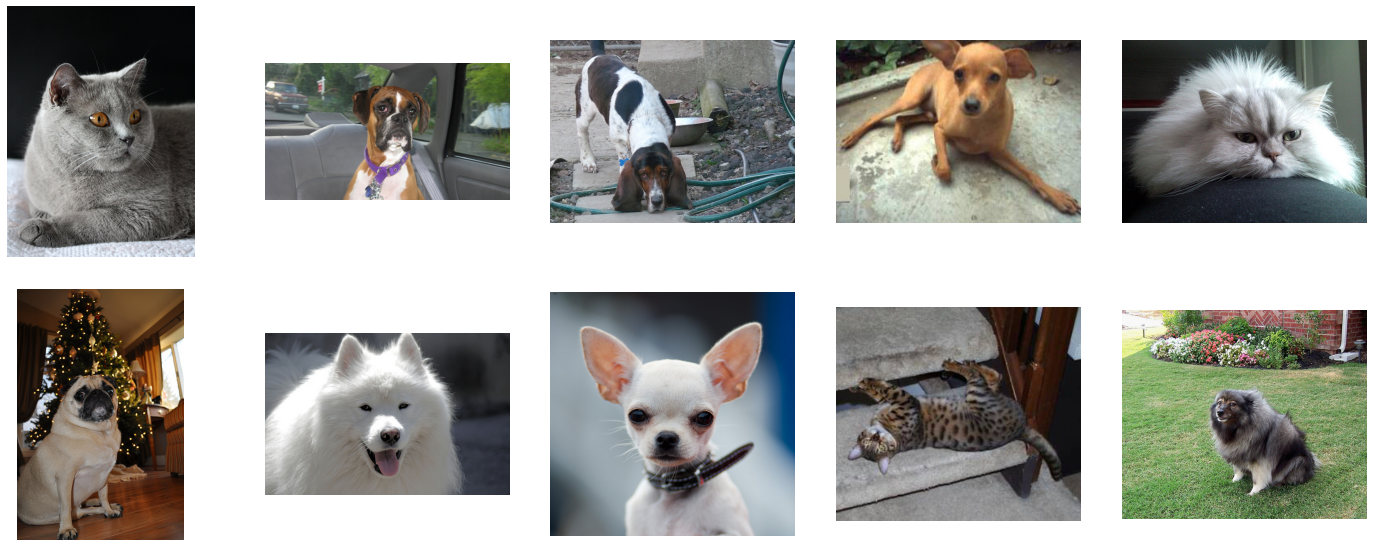

In [6]:
# Path to first batch image file
path = 'data/pet_data/images'

# Get a list of all image file names in the folder
image_files = os.listdir(path)

# Display the first 10 images
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
fig.tight_layout()

for i, image_file in enumerate(image_files[:10]):
    # Open the image using PIL
    image_path = os.path.join(path, image_file)
    image = Image.open(image_path)
    # Display the image
    axs[i // 5, i % 5].imshow(image)
    axs[i // 5, i % 5].axis('off')

plt.show()

## Resize the Images
Resizing the images to 64 by 64. This is because most images are not square. Then the values of the pixels will be normalized at a later time becuase .jpg images cannot be saved with floating point numbers. This section also removes any corrupted images which ultimately shrinks the dataset to 7390 images.

In [7]:
# Path to the folder containing the original images
folder_path = "data/pet_data/images"

# Create a new folder to store the cropped images
output_folder = "data/pet_data/square_images"
os.makedirs(output_folder, exist_ok=True)

# Size of the random crop
crop_size = 64
# Iterate through all the files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith((".jpg", ".jpeg", ".png")):
        # Open the image file
        image_path = os.path.join(folder_path, filename)
        image = cv2.imread(image_path)
                
        # Check if the image was successfully read
        if image is None:
            print(f"Skipping {filename} due to an error in reading the image")
            continue
        
        # Resize the image to the desired size
        cropped_image = cv2.resize(image, (crop_size, crop_size))

        # Save the cropped image to the output folder
        output_path = os.path.join(output_folder, filename)
        cv2.imwrite(output_path, cropped_image)
        

Corrupt JPEG data: premature end of data segment


Skipping Egyptian_Mau_191.jpg due to an error in reading the image
Skipping Abyssinian_34.jpg due to an error in reading the image


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Skipping Egyptian_Mau_145.jpg due to an error in reading the image
Skipping Egyptian_Mau_139.jpg due to an error in reading the image
Skipping Egyptian_Mau_177.jpg due to an error in reading the image
Skipping Egyptian_Mau_167.jpg due to an error in reading the image


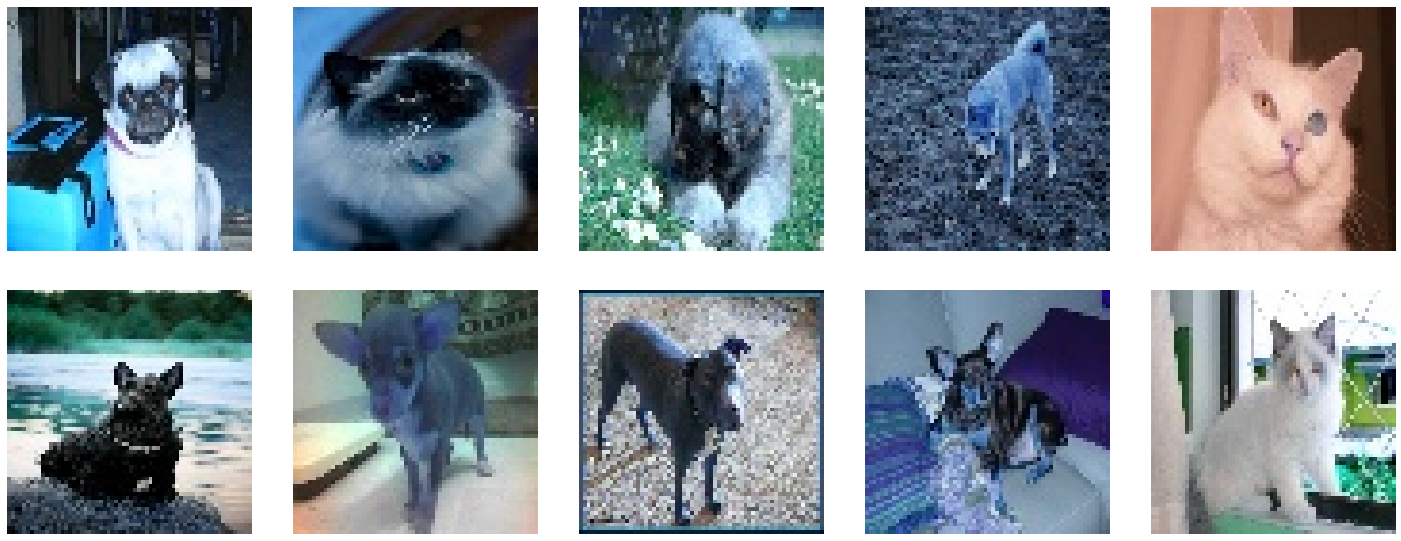

In [7]:
# Path to image files
path = 'data/pet_data/square_images'

# Get a list of all image file names in the folder
image_files = os.listdir(path)

# Display the first 10 images
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
fig.tight_layout()

for i, image_file in enumerate(image_files[:10]):
    # Open the image using cv2
    image_path = os.path.join(path, image_file)
    image = cv2.imread(image_path)
    # Display the image
    axs[i // 5, i % 5].imshow(image)
    axs[i // 5, i % 5].axis('off')

plt.show()

In [9]:
remove_path = 'data/pet_data/square_images/.ipynb_checkpoints'
if os.path.exists(remove_path):
    os.rmdir(remove_path)
    print("`.ipynb_checkpoints` folder deleted.")
else:
    print("`.ipynb_checkpoints` folder does not exist.")

`.ipynb_checkpoints` folder does not exist.


## Faces Dataset

## Show First 10 Images
After downloading the face dataset, we show the first ten images.

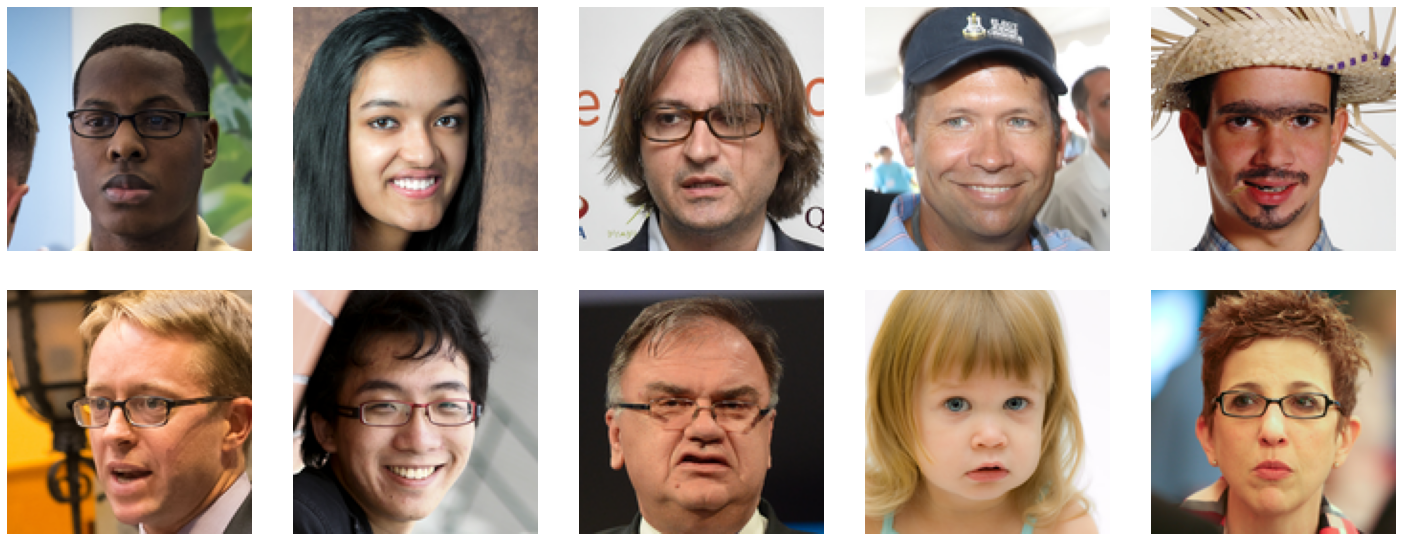

In [3]:
# Path to first batch image file
path = 'data/face_data/00000'

# Get a list of all image file names in the folder
image_files = os.listdir(path)

# Display the first 10 images
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
fig.tight_layout()

for i, image_file in enumerate(image_files[:10]):
    # Open the image using PIL
    image_path = os.path.join(path, image_file)
    image = Image.open(image_path)
    # Display the image
    axs[i // 5, i % 5].imshow(image)
    axs[i // 5, i % 5].axis('off')

plt.show()

## Resizing the Images
Resizing the images to 64 by 64. This is because the images are 128x128, which is too big. Then the values of the pixels will be normalized at a later time in the transformer.

In [16]:
# Path to the folder containing the original images
folder_path = "data/face_data/10000" # change it to use all 10 folders zipped

# Create a new folder to store the cropped images
output_folder = "data/face_data/images"
os.makedirs(output_folder, exist_ok=True)

# Size of the random crop
crop_size = 64
# Iterate through all the files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith((".jpg", ".jpeg", ".png")):
        # Open the image file
        image_path = os.path.join(folder_path, filename)
        image = cv2.imread(image_path)
                
        # Check if the image was successfully read
        if image is None:
            print(f"Skipping {filename} due to an error in reading the image")
            continue
        
        # Resize the image to the desired size
        cropped_image = cv2.resize(image, (crop_size, crop_size))

        # Save the cropped image to the output folder
        output_path = os.path.join(output_folder, filename)
        cv2.imwrite(output_path, cropped_image)

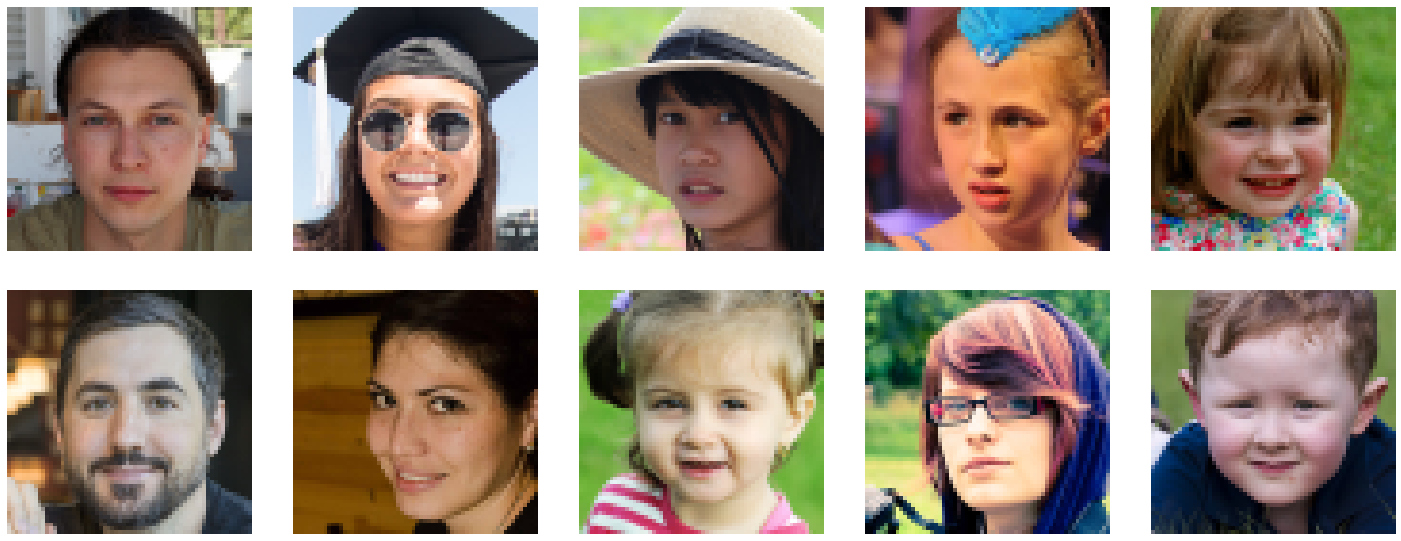

In [2]:
# Path to image files
path = 'data/face_data/images'

# Get a list of all image file names in the folder
image_files = os.listdir(path)

# Display the first 10 images
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
fig.tight_layout()

for i, image_file in enumerate(image_files[:10]):
    # Open the image using cv2
    image_path = os.path.join(path, image_file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGRA2RGB)
    # Display the image
    axs[i // 5, i % 5].imshow(image)
    axs[i // 5, i % 5].axis('off')

plt.show()

# Part III. DCGAN
In this part we are going to make a DCGAN to be trained with the dataset of 64 by 64 pixel square images. The resolution of the images reduces greatly, but for the sake of computational efficiency and because of the paper guidelines, we chose to make resize the images to be 64 by 64.

## Load the Data
Loading in the clean image data into a tensor. Images have to be normalized in this process. This is the training data that will be used. Since the images are not in a subclass folder system, i.e. they are all in the same folder, a custom Dataset class needs to be created that can load them into a tensor, apply transforms, and return the length of the dataset. 

In [2]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.imgs = os.listdir(root_dir)
    
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.imgs[idx])
        image = Image.open(img_path).convert("RGB")  # Convert to color
        
        if self.transform is not None:
            image = self.transform(image)

        return image
    
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

path = 'data/pet_data/square_images'
train_pet_dataset = CustomDataset(path, transform=transform)
train_pet_dataset = torch.utils.data.Subset(train_pet_dataset, range(7296))

path = 'data/face_data/images'
train_face_dataset = CustomDataset(path, transform=transform)
train_face_dataset = torch.utils.data.Subset(train_face_dataset, range(10880))


# Batch size during training
batch_size = 128
workers = 2

# Create the dataloaders
dataloader_pet = torch.utils.data.DataLoader(train_pet_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

dataloader_face = torch.utils.data.DataLoader(train_face_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)


In [40]:
print(train_face_dataset.__len__()) # confirm type tensor
print(train_face_dataset.__getitem__(10879)) # confirm normalization between [-1,1]

10880
tensor([[[-0.7804, -0.7961, -0.7961,  ..., -0.9294, -0.8588, -0.8353],
         [-0.7882, -0.7882, -0.7882,  ..., -0.8667, -0.7961, -0.7255],
         [-0.7961, -0.7961, -0.7961,  ..., -0.7333, -0.6314, -0.5216],
         ...,
         [-0.2392, -0.0902, -0.0353,  ..., -0.7961, -0.8588, -0.8745],
         [-0.4039, -0.3255, -0.2235,  ..., -0.7804, -0.8196, -0.8588],
         [-0.6157, -0.4510, -0.5373,  ..., -0.8196, -0.7725, -0.8196]],

        [[-0.6392, -0.6392, -0.6471,  ..., -0.9294, -0.8745, -0.8431],
         [-0.6471, -0.6392, -0.6471,  ..., -0.8824, -0.8196, -0.7490],
         [-0.6471, -0.6471, -0.6471,  ..., -0.7647, -0.6784, -0.5765],
         ...,
         [-0.5608, -0.4275, -0.3804,  ..., -0.8275, -0.8745, -0.8824],
         [-0.6627, -0.6157, -0.5373,  ..., -0.8353, -0.8431, -0.8745],
         [-0.8118, -0.6941, -0.7647,  ..., -0.8667, -0.8118, -0.8431]],

        [[-0.3176, -0.3176, -0.3176,  ..., -0.9294, -0.8745, -0.8588],
         [-0.3255, -0.3176, -0.3333,  .

### Initializing the Weights

From the DCGAN paper, the authors specify that all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02. The weights_init function takes an initialized model as input and reinitializes all convolutional, convolutional-transpose, and batch normalization layers to meet this criteria. This function is applied to the models immediately after initialization.

In [3]:
# custom weights initialization called on generator model and discriminator
def weights_init(model):
    classname = model.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

### Initialization Values
Values to be intialized to use the generator network.

In [4]:
# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (generator input)
z = 100

# Size of features in generator and discriminator
feat_g = 64
feat_d = 64

## Building the Generator Network

Making the generator class. I will be using nn.Module, I find it easier to debug than nn.Sequential. We have 5 total convolutions. The first 4 convolutions all use BatchNorm and ReLU, no bias. The last convolution uses a tanh activation function instead, and no normalization. This is all explicitly following the steps in the DCGAN paper.

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.conv1 = nn.ConvTranspose2d(in_channels=z, out_channels=feat_g * 8, kernel_size=4, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(feat_g * 8)
        self.relu1 = nn.ReLU(True)
        
        self.conv2 = nn.ConvTranspose2d(feat_g * 8, feat_g * 4, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(feat_g * 4)
        self.relu2 = nn.ReLU(True)
        
        self.conv3 = nn.ConvTranspose2d(feat_g * 4, feat_g * 2, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(feat_g * 2)
        self.relu3 = nn.ReLU(True)
        
        self.conv4 = nn.ConvTranspose2d(feat_g * 2, feat_g, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(feat_g)
        self.relu4 = nn.ReLU(True)
        
        self.conv5 = nn.ConvTranspose2d(feat_g, nc, 4, 2, 1, bias=False)
        self.tanh = nn.Tanh()
        
    def forward(self, noise):
        x = self.conv1(noise)
        x = self.bn1(x)
        x = self.relu1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        
        x = self.conv5(x)
        output = self.tanh(x)
        
        return output

### Initializing the Generator
We begin by initializing several values which include the size of the latent space, the size of our images, and the hyperparameters such as training epochs, learning rate, and beta values for Adam. After that we instantiate the generator and apply the weights from the weights class we created above.

In [6]:
# Create the generator
G = Generator().to(device)

# Apply the ``weights_init`` function to randomly initialize all weights to ``mean=0``, ``stdev=0.02``.
G.apply(weights_init)

# Print the model
print(G)

Generator(
  (conv1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (conv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace=True)
  (conv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU(inplace=True)
  (conv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU(inplace=True)
  (conv5): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (tanh): Tanh()
)


## Building the Discriminator Network
Making the discriminator class. The discriminator has 5 convolutional layers. The first 4 use leaky ReLU as the activation function, and BatchNorm. The last one uses a sigmoid activation function and no normalization. 

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=nc, out_channels=feat_d, kernel_size=4, stride=2, padding=1, bias=False)
        self.leakyrelu1 = nn.LeakyReLU(0.2, inplace=True)
        
        self.conv2 = nn.Conv2d(feat_d, feat_d * 2, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(feat_d * 2)
        self.leakyrelu2 = nn.LeakyReLU(0.2, inplace=True)
        
        self.conv3 = nn.Conv2d(feat_d * 2, feat_d * 4, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(feat_d * 4)
        self.leakyrelu3 = nn.LeakyReLU(0.2, inplace=True)
        
        self.conv4 = nn.Conv2d(feat_d * 4, feat_d * 8, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(feat_d * 8)
        self.leakyrelu4 = nn.LeakyReLU(0.2, inplace=True)
        
        self.conv5 = nn.Conv2d(feat_d * 8, 1, 4, 1, 0, bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, image):
        x = self.conv1(image)
        x = self.leakyrelu1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.leakyrelu2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.leakyrelu3(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.leakyrelu4(x)
        
        x = self.conv5(x)
        output = self.sigmoid(x)
        
        return output

### Initializing the Discriminator
We instantiate the discriminator and apply the weights from the weights class we created above.

In [8]:
# Create the Discriminator
D = Discriminator().to(device)

# Apply the ``weights_init`` function to randomly initialize all weights like this: ``to mean=0, stdev=0.2``.
D.apply(weights_init)

# Print the model
print(D)

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (leakyrelu1): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leakyrelu2): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leakyrelu3): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leakyrelu4): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (sigmoid): Sigmoid()
)


# Part IV. Loss Functions and Optimizers
The optimizer we will use is the same as that in the paper which is Adam. The loss function we will be using to begin with is Binary Cross Entropy loss (BCELoss). 

## Initializing the Loss and Optimizers
The first step is to initialize the BCE Loss and to initialize the optimizers for the generator and discriminator respectively. We set out fake labels as 0 and the real labels as 1. The values for the optimizer hyperparameters are those taken from the paper. We will be initializing another 2 optimizers for the face dataset. This way we can train the pet and face dataset separately.

In [9]:
# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Spatial size of training images
image_size = 64

# Initialize the ``BCELoss`` function
loss = nn.BCELoss()

# Create batch of latent vectors that we will use as input to the generator
fixed_noise = torch.randn(64, z, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerG = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))

# Part V. Training
This is the part where we will train our generator and discriminator! This step is split into 2 parts, the first is where the Discriminator is updated and the second is where the Generator is updated. We will be training the pet and face datasets for 100 epochs. When running the training code, only one of the datasets can be trained at a time, if the other one needs to be trained we need to re-initialize G, D, and the optimizers.

## Training Loop
We will have a training loop where we will train the datasets. The first part of the loop trains the discriminator. The discriminator is trained with both real and fake (generated) images. The second part of the loop trains the generator. The loop returns the images that are generated from our generator, the loss from G and D, and the number of iterations for plotting purposes.

In [10]:
def train_discriminator(D, data, label, fake_batch):
    # Train with real batch
    D.zero_grad()
    real_batch = data.to(device)
    # Forward pass real batch through D
    output = D(real_batch).view(-1)
    # D loss on real batch
    scoreD_real = loss(output, label)
    # Backward pass real batch through D, find gradients
    scoreD_real.backward()
    D_x = output.mean().item()
    
    # Train with fake batch
    label.fill_(fake_label)
    # Forward pass fake batch through D
    output = D(fake_batch.detach()).view(-1)
    # D loss on fake batch
    scoreD_fake = loss(output, label)
    # Backward pass fake batch through D, find gradients
    scoreD_fake.backward()
    D_G_z1 = output.mean().item()
    # Error score of D is sum of fake and real batch score
    scoreD = scoreD_real + scoreD_fake
    # update D
    optimizerD.step()
    
    return scoreD.item(), D_G_z1, D_x

def train_generator(G, D, label, fake_batch):
    G.zero_grad()
    label.fill_(real_label) # fake labels are real for generator cost
    # run generated batch through D again
    output = D(fake_batch).view(-1) 
    # G loss based on previous output
    G_loss_val = loss(output, label)
    # Backward pass through G, find gradients
    G_loss_val.backward()
    D_G_z2 = output.mean().item()
    # update G
    optimizerG.step()
    
    return G_loss_val.item(), D_G_z2

# Training Loop
def train_loop(dataloader, epochs):
    
    # Lists to keep track of progress
    img_list = []
    G_loss = []
    D_loss = []
    iters = 0

    print("Starting Training Loop...")
    # For each epoch
    for epoch in range(epochs):
        # For each batch in the dataloader
        for i, data in enumerate(dataloader, 0):
        
            label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
            noise = torch.randn(batch_size, z, 1, 1, device=device)
            fake_batch = G(noise)
            
            # Update Discriminator network
            scoreD, D_G_z1, D_x = train_discriminator(D, data, label, fake_batch)

            # Update Generator network
            scoreG, D_G_z2 = train_generator(G, D, label, fake_batch)
            
            # Output training stats
            if i % 50 == 0:
                print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                      % (epoch, epochs, scoreD, scoreG, D_x, D_G_z1, D_G_z2))

            # Save Losses for plotting later
            G_loss.append(scoreG)
            D_loss.append(scoreD)

            # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(dataloader)-1)):
                with torch.no_grad():
                    fake = G(fixed_noise).detach().cpu()
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

            iters += 1
    return iters, G_loss, D_loss, img_list

## Training the Pet Dataset
This is where we train the pet dataset for 100 epochs and save it to load again later.

In [50]:
# Number of training epochs
epochs = 100

iters, G_loss, D_loss, img_list = train_loop(dataloader_pet, epochs)

model_path = 'models/pet_model.pth'

torch.save({'epoch': 100,
            'G_model_state_dict': G.state_dict(),
            'G_optimizer_state_dict': optimizerG.state_dict(),
            'D_model_state_dict': D.state_dict(),
            'D_optimizer_state_dict': optimizerD.state_dict(),
            'G_loss': G_loss,
            'D_loss': D_loss,
           'D_learning_rate': lr,
           'G_learning_rate': lr,
           'input_dim': 3,
           'latent_dim': 100},
          model_path)

Starting Training Loop...
[0/100]	Loss_D: 1.5474	Loss_G: 6.9877	D(x): 0.6291	D(G(z)): 0.5554 / 0.0017
[0/100]	Loss_D: 0.5150	Loss_G: 20.3412	D(x): 0.7318	D(G(z)): 0.0000 / 0.0000
[1/100]	Loss_D: 1.7304	Loss_G: 15.7649	D(x): 0.8190	D(G(z)): 0.7016 / 0.0000
[1/100]	Loss_D: 0.7944	Loss_G: 5.0104	D(x): 0.8281	D(G(z)): 0.4045 / 0.0112
[2/100]	Loss_D: 0.7391	Loss_G: 5.7208	D(x): 0.8249	D(G(z)): 0.3657 / 0.0065
[2/100]	Loss_D: 1.0366	Loss_G: 5.3272	D(x): 0.7897	D(G(z)): 0.4989 / 0.0082
[3/100]	Loss_D: 0.7357	Loss_G: 4.1783	D(x): 0.8149	D(G(z)): 0.3621 / 0.0203
[3/100]	Loss_D: 0.5744	Loss_G: 5.7037	D(x): 0.7946	D(G(z)): 0.1381 / 0.0049
[4/100]	Loss_D: 0.6675	Loss_G: 7.1251	D(x): 0.8299	D(G(z)): 0.3268 / 0.0022
[4/100]	Loss_D: 1.5057	Loss_G: 11.3827	D(x): 0.4369	D(G(z)): 0.0004 / 0.0002
[5/100]	Loss_D: 0.4858	Loss_G: 6.1944	D(x): 0.8537	D(G(z)): 0.2005 / 0.0030
[5/100]	Loss_D: 0.4053	Loss_G: 4.5304	D(x): 0.9390	D(G(z)): 0.2707 / 0.0164
[6/100]	Loss_D: 0.2590	Loss_G: 3.6934	D(x): 0.8653	D(G(z)):

[53/100]	Loss_D: 0.4290	Loss_G: 3.8077	D(x): 0.8148	D(G(z)): 0.1711 / 0.0356
[54/100]	Loss_D: 0.2315	Loss_G: 4.3785	D(x): 0.8520	D(G(z)): 0.0520 / 0.0212
[54/100]	Loss_D: 0.6776	Loss_G: 1.8299	D(x): 0.6084	D(G(z)): 0.0939 / 0.2161
[55/100]	Loss_D: 0.4290	Loss_G: 5.4068	D(x): 0.9353	D(G(z)): 0.2605 / 0.0080
[55/100]	Loss_D: 0.5773	Loss_G: 2.8858	D(x): 0.7355	D(G(z)): 0.1728 / 0.0902
[56/100]	Loss_D: 0.4015	Loss_G: 4.5642	D(x): 0.9139	D(G(z)): 0.2196 / 0.0212
[56/100]	Loss_D: 0.5342	Loss_G: 3.0515	D(x): 0.6686	D(G(z)): 0.0501 / 0.0758
[57/100]	Loss_D: 0.4613	Loss_G: 3.2406	D(x): 0.6932	D(G(z)): 0.0397 / 0.0605
[57/100]	Loss_D: 0.5854	Loss_G: 3.4549	D(x): 0.6218	D(G(z)): 0.0276 / 0.0660
[58/100]	Loss_D: 0.2511	Loss_G: 4.0672	D(x): 0.8745	D(G(z)): 0.0864 / 0.0292
[58/100]	Loss_D: 0.3858	Loss_G: 5.1893	D(x): 0.9361	D(G(z)): 0.2409 / 0.0116
[59/100]	Loss_D: 0.5243	Loss_G: 5.8760	D(x): 0.9688	D(G(z)): 0.3468 / 0.0045
[59/100]	Loss_D: 0.7133	Loss_G: 6.2264	D(x): 0.9045	D(G(z)): 0.3956 / 0.0038

## Train Face Dataset
This is where we train the face dataset for 100 epochs and save it to load again later.

In [45]:
# Number of training epochs
epochs = 100

iters, G_loss, D_loss, img_list = train_loop(dataloader_face, epochs)

model_path = 'models/face_model.pth'

torch.save({'epoch': 100,
            'G_model_state_dict': G.state_dict(),
            'G_optimizer_state_dict': optimizerG.state_dict(),
            'D_model_state_dict': D.state_dict(),
            'D_optimizer_state_dict': optimizerD.state_dict(),
            'G_loss': G_loss,
            'D_loss': D_loss,
           'D_learning_rate': lr,
           'G_learning_rate': lr,
           'input_dim': 3,
           'latent_dim': 100},
          model_path)

Starting Training Loop...
[0/100]	Loss_D: 0.7285	Loss_G: 13.2381	D(x): 0.7230	D(G(z)): 0.0016 / 0.0001
[0/100]	Loss_D: 0.6619	Loss_G: 5.9956	D(x): 0.8345	D(G(z)): 0.3132 / 0.0062
[1/100]	Loss_D: 0.5011	Loss_G: 5.6114	D(x): 0.8669	D(G(z)): 0.2269 / 0.0073
[1/100]	Loss_D: 1.0917	Loss_G: 6.3661	D(x): 0.5270	D(G(z)): 0.0073 / 0.0046
[2/100]	Loss_D: 0.6144	Loss_G: 3.8791	D(x): 0.7351	D(G(z)): 0.1466 / 0.0373
[2/100]	Loss_D: 1.0877	Loss_G: 7.8747	D(x): 0.9448	D(G(z)): 0.5614 / 0.0011
[3/100]	Loss_D: 0.4637	Loss_G: 2.9981	D(x): 0.7706	D(G(z)): 0.0840 / 0.1024
[3/100]	Loss_D: 0.4755	Loss_G: 5.3196	D(x): 0.8011	D(G(z)): 0.1383 / 0.0104
[4/100]	Loss_D: 0.4203	Loss_G: 4.5565	D(x): 0.9259	D(G(z)): 0.2528 / 0.0206
[4/100]	Loss_D: 0.8347	Loss_G: 8.3353	D(x): 0.5625	D(G(z)): 0.0016 / 0.0005
[5/100]	Loss_D: 0.5490	Loss_G: 4.8610	D(x): 0.8599	D(G(z)): 0.2662 / 0.0146
[5/100]	Loss_D: 0.5773	Loss_G: 5.7895	D(x): 0.7178	D(G(z)): 0.0593 / 0.0060
[6/100]	Loss_D: 0.7227	Loss_G: 4.0721	D(x): 0.7194	D(G(z)): 0

[53/100]	Loss_D: 0.3475	Loss_G: 3.3494	D(x): 0.8067	D(G(z)): 0.1052 / 0.0603
[54/100]	Loss_D: 0.2060	Loss_G: 3.2328	D(x): 0.9143	D(G(z)): 0.1018 / 0.0551
[54/100]	Loss_D: 0.7040	Loss_G: 3.9306	D(x): 0.9334	D(G(z)): 0.3979 / 0.0367
[55/100]	Loss_D: 0.2857	Loss_G: 3.8075	D(x): 0.7997	D(G(z)): 0.0355 / 0.0394
[55/100]	Loss_D: 0.3376	Loss_G: 3.5989	D(x): 0.9213	D(G(z)): 0.2031 / 0.0409
[56/100]	Loss_D: 0.3292	Loss_G: 3.5369	D(x): 0.8772	D(G(z)): 0.1608 / 0.0428
[56/100]	Loss_D: 0.3339	Loss_G: 3.8553	D(x): 0.8712	D(G(z)): 0.1554 / 0.0346
[57/100]	Loss_D: 0.4296	Loss_G: 4.6603	D(x): 0.9337	D(G(z)): 0.2715 / 0.0139
[57/100]	Loss_D: 0.7055	Loss_G: 4.5327	D(x): 0.8797	D(G(z)): 0.3876 / 0.0179
[58/100]	Loss_D: 0.2301	Loss_G: 3.4653	D(x): 0.9236	D(G(z)): 0.1285 / 0.0448
[58/100]	Loss_D: 0.3491	Loss_G: 2.4554	D(x): 0.7685	D(G(z)): 0.0542 / 0.1210
[59/100]	Loss_D: 0.7341	Loss_G: 6.6248	D(x): 0.9099	D(G(z)): 0.4073 / 0.0026
[59/100]	Loss_D: 0.2752	Loss_G: 3.2207	D(x): 0.8964	D(G(z)): 0.1395 / 0.0555

# Part VI. Results
Here we show the results from the GAN. Those are the images that are generated from the generator and a plot of the loss from the discriminator and generator.

In [24]:
def show_loss(G_loss, D_loss):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_loss,label="G")
    plt.plot(D_loss,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    pass

In [25]:
def image_comparison(dataloader, img_list):
    # Grab a batch of real images from the dataloader
    real_batch = next(iter(dataloader))

    # Plot the real images
    plt.figure(figsize=(15,15))
    plt.subplot(1,2,1)
    plt.axis("off")
    plt.title("Real Images")
    plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

    # Plot the generated images from the last epoch
    plt.subplot(1,2,2)
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(np.transpose(img_list[-1],(1,2,0)))
    plt.show()
    
    pass

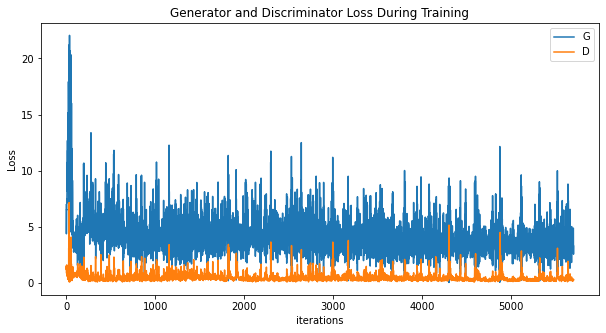

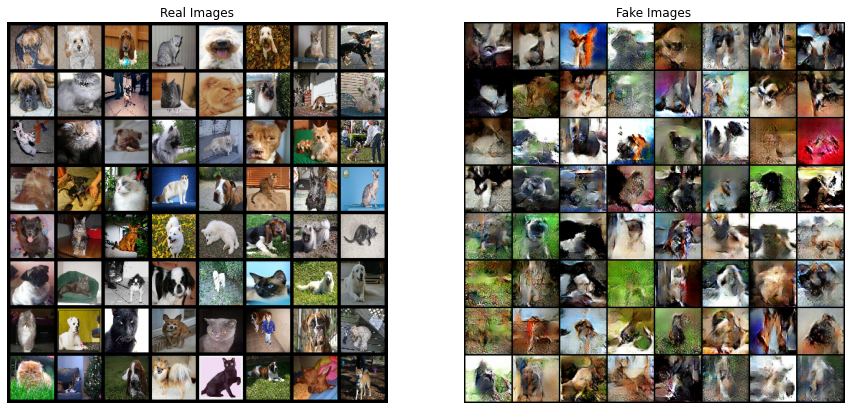

In [53]:
show_loss(G_loss, D_loss)
image_comparison(dataloader_pet, img_list)

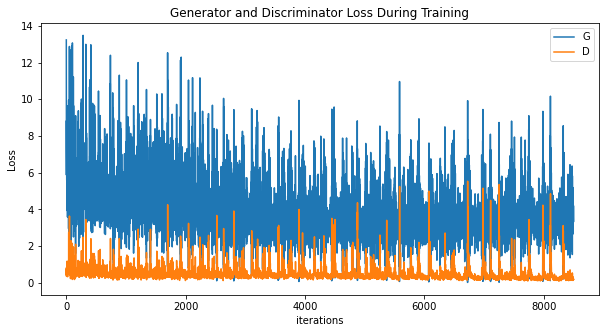

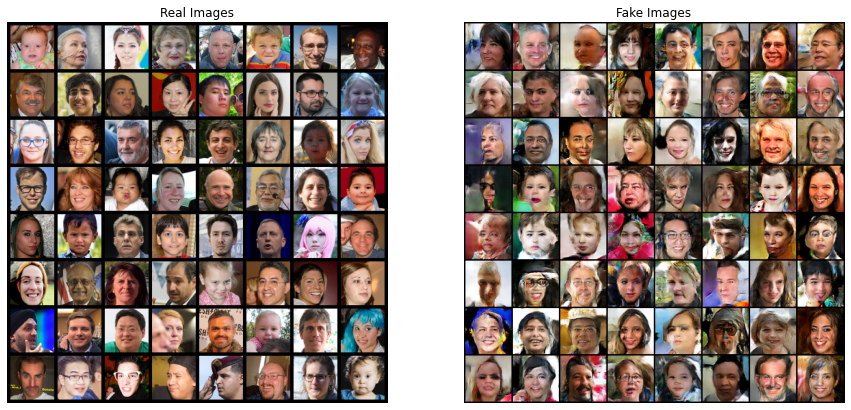

In [46]:
show_loss(G_loss, D_loss)
image_comparison(dataloader_face, img_list)

# Part VII. Supervised Learning - Setup
In this part we are going to use the DCGAN as a feature extractor on a new dataset to do supervised learning. For this we need to reload the previously trained models and download and clean a new dataset. In this case we will be using COCO 2017 validation images. After this we will be able to do the feature extraction necessary for the supervised learning.

## Reloading the Model
This is to reinitialize the models to confirm that we can load in the saved weights.

In [10]:
# Create new Discriminator and Generator
D_new_pet = Discriminator().to(device)
G_new_pet = Generator().to(device)

In [11]:
# load state dicts
checkpoint = torch.load('models/pet_model.pth')

D_new_pet.load_state_dict(checkpoint['D_model_state_dict'])
G_new_pet.load_state_dict(checkpoint['G_model_state_dict'])

<All keys matched successfully>

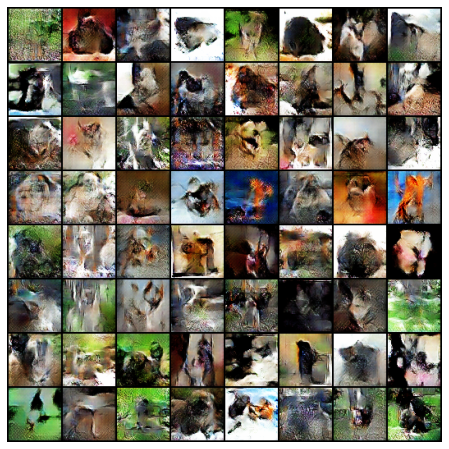

In [12]:
from torchvision.utils import make_grid

# define noise and generate samples from generator
noise = torch.randn(64, z, 1, 1, device=device)
noise = noise.to(device=device)

with torch.no_grad():
    fake = G_new_pet(noise).detach().cpu()
    img_grid = make_grid(fake, normalize=True)
    
plt.figure(figsize=(8,8))
plt.axis("off")
plt.imshow(np.transpose(img_grid,(1,2,0)))
plt.show()

In [13]:
# Create new Discriminator and Generator
D_new_face = Discriminator().to(device)
G_new_face = Generator().to(device)

In [14]:
# load state dicts
checkpoint = torch.load('models/face_model.pth')

D_new_face.load_state_dict(checkpoint['D_model_state_dict'])
G_new_face.load_state_dict(checkpoint['G_model_state_dict'])

<All keys matched successfully>

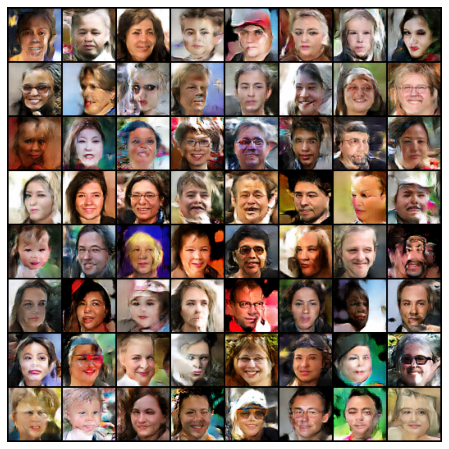

In [15]:
from torchvision.utils import make_grid

# define noise and generate samples from generator
noise = torch.randn(64, z, 1, 1, device=device)
noise = noise.to(device=device)

with torch.no_grad():
    fake = G_new_face(noise).detach().cpu()
    img_grid = make_grid(fake, normalize=True)
    
plt.figure(figsize=(8,8))
plt.axis("off")
plt.imshow(np.transpose(img_grid,(1,2,0)))
plt.show()

## Downloading COCO Dataset
I downloaded the COCO Stuff, Validation dataset from 2017. This dataset is 5000 images long in PNG format and they are all in different sizes. These need to be made 64 by 64 to pass through the Feature Extraction class.

In [16]:
from pycocotools.coco import COCO
import json

# Specify the paths to the annotation files
annotation_path = 'data/coco/annotations/stuff_val2017.json'
image_directory = 'data/coco/val2017'  # path to the directory containing validation images

# Create a COCO object
coco = COCO(annotation_path)

# Load categories
categories = coco.loadCats(coco.getCatIds())
category_names = [category['name'] for category in categories]
print('Loaded', len(category_names), 'categories:', category_names)

# Load images
image_ids = coco.getImgIds()
images = coco.loadImgs(image_ids)
print('Loaded', len(images), 'images.')

loading annotations into memory...
Done (t=0.56s)
creating index...
index created!
Loaded 92 categories: ['banner', 'blanket', 'branch', 'bridge', 'building-other', 'bush', 'cabinet', 'cage', 'cardboard', 'carpet', 'ceiling-other', 'ceiling-tile', 'cloth', 'clothes', 'clouds', 'counter', 'cupboard', 'curtain', 'desk-stuff', 'dirt', 'door-stuff', 'fence', 'floor-marble', 'floor-other', 'floor-stone', 'floor-tile', 'floor-wood', 'flower', 'fog', 'food-other', 'fruit', 'furniture-other', 'grass', 'gravel', 'ground-other', 'hill', 'house', 'leaves', 'light', 'mat', 'metal', 'mirror-stuff', 'moss', 'mountain', 'mud', 'napkin', 'net', 'paper', 'pavement', 'pillow', 'plant-other', 'plastic', 'platform', 'playingfield', 'railing', 'railroad', 'river', 'road', 'rock', 'roof', 'rug', 'salad', 'sand', 'sea', 'shelf', 'sky-other', 'skyscraper', 'snow', 'solid-other', 'stairs', 'stone', 'straw', 'structural-other', 'table', 'tent', 'textile-other', 'towel', 'tree', 'vegetable', 'wall-brick', 'wall-

## Get Image Labels
We need the labels of the images. Since the images don't have easily attainable annotations, we have to go through every image and get its categegory.

In [17]:
# Create a mapping of category names to integer labels
label_map = {category_name: index for index, category_name in enumerate(category_names)}

# Get image labels as integer labels
image_labels = []
for image in images:
    image_id = image['id']
    annotations_ids = coco.getAnnIds(imgIds=image_id)
    annotations = coco.loadAnns(annotations_ids)
    
    # Consider only the first category
    if len(annotations) > 0:
        label_id = annotations[0]['category_id']
        label_name = coco.loadCats(label_id)[0]['name']
        label = label_map[label_name]  # Get the integer label from the mapping
        image_labels.append(label)
    else:
        # Handle the case when no annotations are available for an image
        # You can either skip such images or assign a special label for them
        # Here, we assign a label of -1 for images with no annotations
        image_labels.append(-1)

# Print the integer labels
print('Image labels:', len(image_labels))

Image labels: 5000


In [18]:
# Get labels for the subset of coco images
labels_subset = image_labels[:4992]
print(len(labels_subset))

4992


## Show First 10 Images

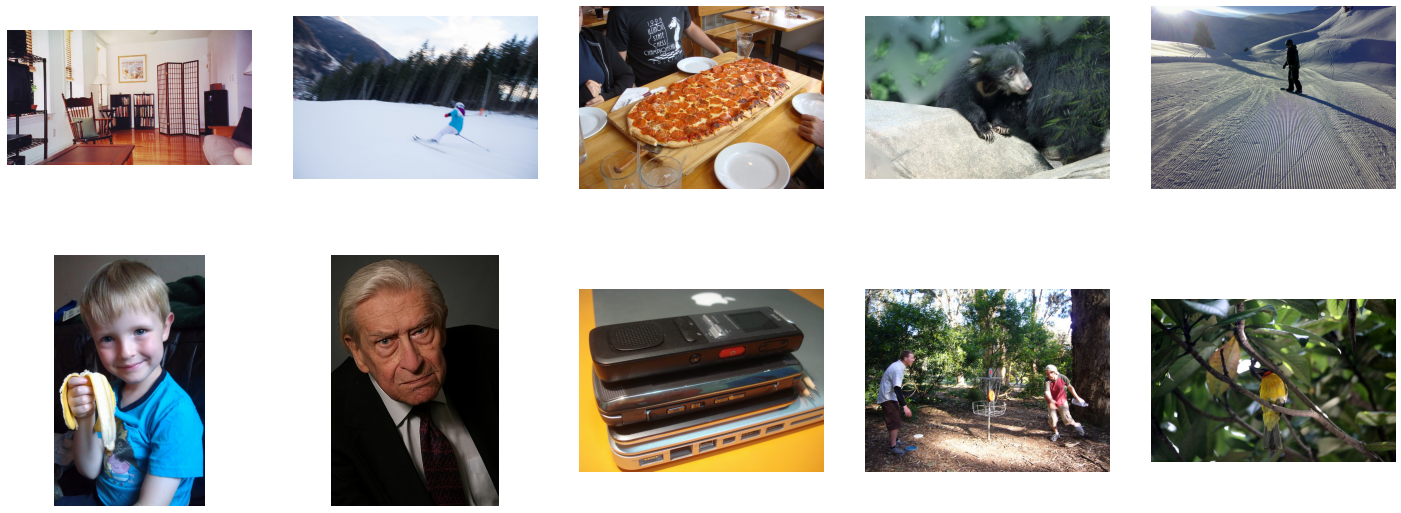

In [12]:
# Path to first batch image file
path = 'data/coco/val2017'

# Get a list of all image file names in the folder
image_files = os.listdir(path)

# Display the first 10 images
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
fig.tight_layout()

for i, image_file in enumerate(image_files[:10]):
    # Open the image using PIL
    image_path = os.path.join(path, image_file)
    image = Image.open(image_path)
    # Display the image
    axs[i // 5, i % 5].imshow(image)
    axs[i // 5, i % 5].axis('off')

plt.show()

## Resizing the Images
The sizes will be resized to be 64x64.

In [19]:
from torchvision.transforms import Resize
from torchvision.datasets import CocoDetection

# Specify the paths to the annotation files
annotation_path = 'data/coco/annotations/stuff_val2017.json'
image_directory = 'data/coco/val2017'  # path to the directory containing validation images

# Custom dataset class for COCO
class CocoResizedDataset(torch.utils.data.Dataset):
    def __init__(self, annotation_path, image_directory, transform=None):
        self.coco = CocoDetection(image_directory, annotation_path)
        self.transform = transform

    def __getitem__(self, index):
        image, _ = self.coco[index]
        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.coco)
    
crop_size = (64, 64)

# Define the transformations
transform = T.Compose([
    Resize(crop_size),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create the resized dataset
coco_dataset = CocoResizedDataset(annotation_path, image_directory, transform=transform)
coco_dataset = torch.utils.data.Subset(coco_dataset, range(4992))

# Create the DataLoader for the resized dataset
batch_size = 128
dataloader_coco = torch.utils.data.DataLoader(coco_dataset, batch_size=batch_size, shuffle=False)

loading annotations into memory...
Done (t=0.39s)
creating index...
index created!


### See Resized Images

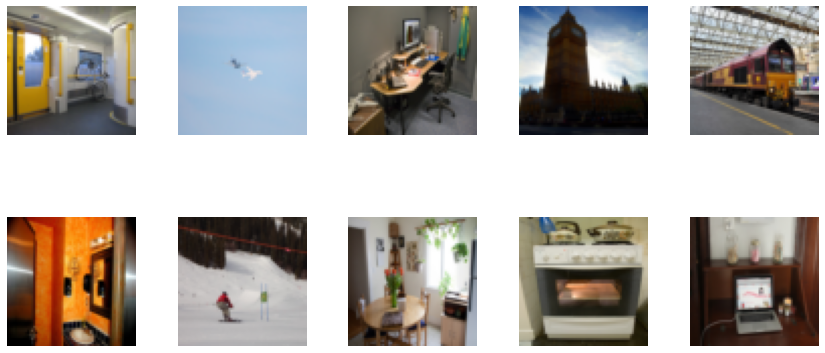

In [39]:
# Initialize a figure and axis
fig, axs = plt.subplots(2, 5, figsize=(12, 6))
fig.tight_layout()

# Iterate over the first 10 batches of the DataLoader
for batch_index, batch in enumerate(dataloader_coco):
    # Iterate over the images in the batch
    for image_index, image in enumerate(batch):
        # Display the resized image on the corresponding axis
        ax = axs[image_index // 5, image_index % 5]
        ax.imshow(image.permute(1, 2, 0))  # Convert tensor to image format (C, H, W) -> (H, W, C)
        ax.axis('off')

        # Break the loop after displaying 10 images
        if image_index == 9:
            break

    # Break the loop after displaying 10 batches
    if batch_index == 9:
        break

# Show the figure with all the images
plt.show()

# Part VIII. Supervised Learning - Transfer Learning
This is where we will be using the discriminator from our DCGAN as a feature extraction tool. We will be using these features to do classification on the COCO val2017 dataset. 

## Building Feature Extraction Class
We will be using the convolutional layers of the Discriminator, but not the linear layers, to do the feature extracting. This means the code from the Discriminator will be copied over except for the last layers.

In [20]:
class FeatureExtractor(nn.Module):
    
    def __init__(self, discriminator):
        super(FeatureExtractor, self).__init__()
        self.conv1 = discriminator.conv1
        self.leakyrelu1 = discriminator.leakyrelu1
        
        self.conv2 = discriminator.conv2
        self.bn2 = discriminator.bn2
        self.leakyrelu2 = discriminator.leakyrelu2
        
        self.conv3 = discriminator.conv3
        self.bn3 = discriminator.bn3
        self.leakyrelu3 = discriminator.leakyrelu3
        
        self.conv4 = discriminator.conv4
        self.bn4 = discriminator.bn4
        self.leakyrelu4 = discriminator.leakyrelu4
    
    def forward(self, image):
        x = self.conv1(image)
        x = self.leakyrelu1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.leakyrelu2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.leakyrelu3(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.leakyrelu4(x)
        
        return x

### Initializing Feature Extractor 
We initialize the feature extractor with the discrminator for each of the models.

In [21]:
feature_extractor_pet = FeatureExtractor(D_new_pet)
feature_extractor_face = FeatureExtractor(D_new_face)

## Extracting the Features
We extract the features by passing the COCO dataset through the newly initialized feature extractors. Since these extractors were themselves initialized using the loaded model weights from the trained DCGAN, we will be using these weights to improve our classification of COCO.

In [22]:
feature_extractor_pet.eval()  # Set the model to evaluation mode
feature_extractor_face.eval()  # Set the model to evaluation mode

features_list_pet = []  # List to store the extracted features from pet dataset
features_list_face = []  # List to store the extracted features from face dataset

for images in dataloader_coco:
    images = images.to(device)  # Move the images to the same device as the model
    with torch.no_grad():
        features_pet = feature_extractor_pet(images)
        features_face = feature_extractor_face(images)
        
        features_list_pet.append(features_pet)
        features_list_face.append(features_face)
        

# Concatenate the extracted features
all_features_pet = torch.cat(features_list_pet, dim=0)
all_features_face = torch.cat(features_list_face, dim=0)

In [23]:
print(all_features_pet.shape)
print(all_features_pet[0][0])

torch.Size([4992, 512, 4, 4])
tensor([[-1.3866e-01,  1.6948e+00,  7.9826e-04,  2.0119e-01],
        [ 8.6056e-01,  1.3635e+00, -2.1194e-01,  2.1832e-01],
        [-1.1426e-02,  1.5083e+00,  6.6116e-01,  2.5294e-01],
        [ 1.1662e+00,  1.2131e+00, -2.3914e-01,  3.4869e-01]], device='cuda:0')


# Part IX. Supervised Learning - Building a CNN
We will be using a generic CNN to do image classification. As in the paper we will be implementing the L2-SVM algorithm to train on the previously downloaded COCO dataset. L2-SVM is available in sklearn, so this is what we are using.

## L2-SVM - Pet Dataset


In [60]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(all_features_pet, labels_subset, test_size=0.2, random_state=42)

# Initialize and train the L2-SVM model
svm_model = SVC(kernel='rbf', C=.0001)

# Convert tensors to CPU
X_train = X_train.cpu()
X_val = X_val.cpu()

# Reshape the feature maps
X_train = X_train.view(X_train.size(0), -1)
X_val = X_val.view(X_val.size(0), -1)

svm_model.fit(X_train, y_train)

SVC(C=1e-05)

In [61]:
# Make predictions and evaluate the model
y_pred = svm_model.predict(X_val)

In [62]:
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy: {:.2f}%".format(accuracy * 100))

Validation Accuracy: 17.82%


## L2-SVM - Face Dataset


In [57]:
# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(all_features_face, labels_subset, test_size=0.2, random_state=42)

# Initialize and train the L2-SVM model
svm_model = SVC(kernel='rbf', C=.0001)

# Convert tensors to CPU
X_train = X_train.cpu()
X_val = X_val.cpu()

# Reshape the feature maps
X_train = X_train.view(X_train.size(0), -1)
X_val = X_val.view(X_val.size(0), -1)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

svm_model.fit(X_train, y_train)

SVC(C=0.0001)

In [58]:
# Make predictions and evaluate the model
y_pred = svm_model.predict(X_val)

In [59]:
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy: {:.2f}%".format(accuracy * 100))

Validation Accuracy: 17.82%


# Part X. Algorithm Comparison
Here we will compare how well the other algorithms work to our own DCGAN + L2-SVM combination. The top accuracy we achieved is 17.82%.
This final bit is on my teammates code where we compare multiple algorithms.